# Introductory Tutorial for Extensions of Work
This notebook provides an introduction to working with the preprocessed dataset stored in this repository.

It is intended to familiarize the user with the format of the data, as well as the various helper functions provided by the `Dataset` abstraction.

This tutorial is provided such that those seeking to extend and/or reproduce the results can do so with ease.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/orion-junkins/eeg-connectivity/blob/main/extension_tutorial.ipynb)

## 0) Setup
Import needed files and perform necessary setup. Check if we are in Google Colab and clone the repository if so. Define needed root directory filepath for accessing the data.

In [1]:
import os
import sys
import numpy as np
# Check if the notebook is running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    root_dir = f"/content/eeg-connectivity"
except ImportError:
    IN_COLAB = False
    root_dir = "."

# Clone the repository if in Colab
if IN_COLAB:
    !pip install pingouin==0.5.5 # Install needed stats library
    !pip install mne==1.7.0 # Install MNE
    !git clone https://github.com/orion-junkins/eeg-connectivity.git # Clone repo
    if os.path.exists(root_dir):
        sys.path.append(root_dir) # Add cloned repo to Python path in colab
        print(f"Cloned connectivity repository and added to Python import path.")
    else:
        print(f"Failed to clone repository.")    
else:
    print("Not running in Google Colab. Skipping repository cloning.")

Not running in Google Colab. Skipping repository cloning.


In [2]:
# Imports - definitions of these functions can be found in referenced files
from plotting_utils import plot_heatmap, plot_stacked_triple_ps, plot_condition_diff_avg, plot_condition_diff_avg_2way
from stats_tests import run_rm_anova
from dataset import Dataset

## 1) Load and Explore the Entropy Connectivity Dataset
The `Dataset` abstraction provides lots of helpers for accessing data. It loads all of the connectivity data from the stored `.npy` files in the root directory.

Note that the "excludes" are subjects where at least one of the four required datasets (WiG BL, WiG Demo, NoG BL and NoG Demo) was either missing (due to recording errors) or unusably corrupted (e.g. by line noise or motion artifacts). Some data in these subjects is still usable so these exclusion lists can be modified if exploring that data is desired.

Note that the `connectivity_scores_entropy_5s` corresponds to the connectivity metrics computed from epoched data created in 5 second windows. 

In [3]:
# Load the dataset with all data in the folder "connectivity_scores_shannon_entropy"
data_dir = os.path.join(root_dir, "data")
dataset = Dataset('connectivity_scores_entropy_5s', expert_excludes=["11, 13b", "1"], novice_excludes=["13", "6", "14"], data_dir=data_dir)

To start, lets directly access the numpy array for a singly subject. This can be fetched via the `id_dicts` attribute of the `Dataset`class. Let's grab Expert 9b's Baseline With Gesture data and inspect the shape. Here, the ordering of the indexing is important. Follow this format: 
```
dataset.id_dicts["expert"|"novice"]["BL"|"demo"]["WiG"|"NoG"][id#]
```

In [4]:
dataset.id_dicts["expert"]["BL"]["WiG"]["9b"].shape

(44, 12, 12, 6)

Note that the shape corresponds to $Epochs \times Electrodes \times Electrodes \times Frequencies$. In this case, we have 44 epochs of data at six different frequency levels. To inspect what frequency values are being used, inspect the `frequencies` attribute of the dataset.

In [5]:
dataset.frequencies

['delta', 'theta', 'low alpha', 'high alpha', 'low beta', 'high beta']

The dataset can also tell us the names of the electrodes it has data for.

In [6]:
dataset.electrode_names

array(['F3', 'Fz', 'F4', 'FCz', 'Cz', 'CP3', 'CP4', 'P1', 'Pz', 'P2',
       'PPO1', 'PPO2'], dtype='<U4')

While this is a nice way to access all raw data for a single subject, for multiple subjects it is easier to work with data as numpy arrays. For this, the dataset provides a `numpy_arrays` arrays attribute. Lets isolate all Expert, Baseline, With Gesture data and inspect the shape.

In [7]:
dataset.numpy_arrays["expert"]["BL"]["WiG"].shape

(16, 12, 12, 6)

The shape corresponds to $Subjects \times Electrodes \times Electrodes \times Frequencies$. Note that, for each subject in a given condition, all epochs have now been averaged into a single value for each electrode pair. For all analysis performed in our work, this average across epochs is sufficient. To perform more fine grained epoch level analysis, `id_dicts` must be used.

In general, we will want to isolate a single frequency band. While we could do it with indexing, the dataset provides `get_subset(...)` to make things easier. As an example, lets isolate all Expert/BL/WiG/High Alpha data and inspect the shape.

In [8]:
dataset.get_subset("expert", "BL", "WiG", "high alpha").shape

(16, 12, 12)

Note that now we just have $Subjects \times Electrodes \times Electrodes$ as only high alpha data is present.

Lets grab a random subject (say index 5) and visualize their high alpha data.

`plot_heatmap()` is a convenient helper function for visualizing a 2-dimensional array of data as a heatmap with a few options for formatting.

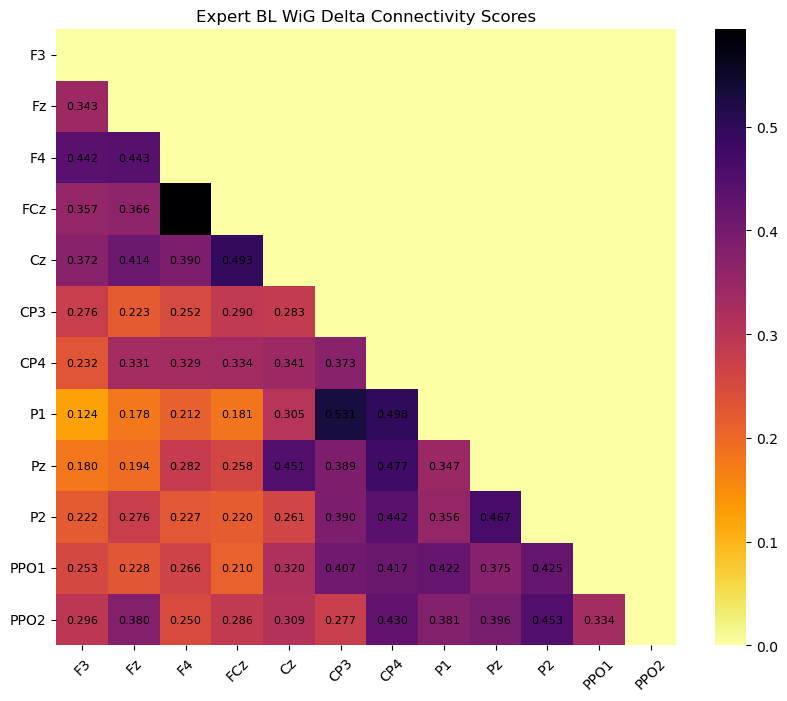

In [9]:
expert_bl_wig_high_alpha = dataset.get_subset("expert", "BL", "WiG", "high alpha")
subject_5_data = expert_bl_wig_high_alpha[5]

plot_heatmap(subject_5_data, dataset.electrode_names, "Expert BL WiG Delta Connectivity Scores")

This shows the raw values for this particular subject at this particular frequency band. Note that this data could be shown as a full matrix, but, because it is symmetric about the diagonal, only the lower triangular portion is shown for clarity.